In [1]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_thetas_grid(min_theta, max_theta):
    theta1 = np.linspace(min_theta, max_theta, 400)
    theta2 = np.linspace(min_theta, max_theta, 400)
    thetas_unflat = np.meshgrid(theta1, theta2)
    return np.vstack((thetas_unflat[0].flatten(), thetas_unflat[1].flatten())).T.astype(np.float32)

<Axes: >

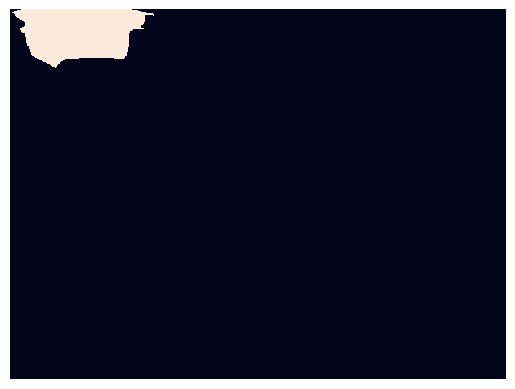

In [4]:
task_name = "gaussian_mixture"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

sims = 10_000 # same number for both test and calibration
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

thetas = get_thetas_grid(-10, 10)
test_sim = 1
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]
test_x_tiled = np.tile(test_x, (thetas.shape[0], 1)).astype(np.float32)

device = "cpu"
cached_fn = os.path.join("trained", f"{task_name}.nf")
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
desired_coverages = [0.75, 0.85, 0.95]
desired_coverage = desired_coverages[-1]
    
probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
probs_map = probs.reshape((400, 400))

conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
sns.heatmap((1 / probs_map) < conformal_quantile, cbar=False, xticklabels=False, yticklabels=False)

In [48]:
from scipy.ndimage.measurements import label
from sklearn.cluster import KMeans

region = ((1 / probs_map) < conformal_quantile).astype(int)
structure = np.ones((3, 3), dtype=int)  # this defines the connection filter
labeled, ncomponents = label(region, structure)

N = 8
total_covered = np.sum(region)
total_rps = 0
true_rps = []

for component in range(1, ncomponents + 1):
    component_prop = np.sum(labeled == component) / total_covered
    if component == ncomponents:
        n = N - total_rps
    else:
        n = int(np.round(component_prop * N))
        total_rps += n

    # location_pairs = np.where(labeled == component)
    # locations = list(zip(location_pairs[0], location_pairs[1]))
    grid_region = thetas[(labeled == component).flatten()]
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(grid_region)
    true_rps.append(kmeans.cluster_centers_)
true_rps = np.vstack(true_rps)

/tmp/ipykernel_3258966/1141430561.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [49]:
T = 5_000 # time steps of repulsive simulation

y_hat = encoder.sample(N, test_x)[0].detach().cpu().numpy()
test_x_tiled = np.tile(test_x, (y_hat.shape[0], 1)).astype(np.float32)
trajectory = []
eta = 0.01

for _ in range(T):
    proposed_y_hat = y_hat.copy() + eta * np.random.randn(y_hat.shape[0], y_hat.shape[1]).astype(np.float32)
    proposed_probs = encoder.log_prob(proposed_y_hat, test_x_tiled).detach().cpu().exp().numpy()

    in_region = (1 / proposed_probs) < conformal_quantile
    y_hat[in_region] = proposed_y_hat[in_region]
    trajectory.append(y_hat.copy())
trajectory = np.array(trajectory)

In [50]:
import random
from scipy import spatial

def get_rps(trajectory):
    remaining_traj_idxs = set(range(N))
    final_trajs = []
    ns = []
    dist_thresh = 0.01
    while len(remaining_traj_idxs) > 0:
        root_traj_idx = remaining_traj_idxs.pop()
        connected_trajs = [trajectory[:,root_traj_idx,:]]
        connected_traj_idxs = set()
        
        tree = spatial.KDTree(trajectory[:,root_traj_idx,:])
        for traj_idx in remaining_traj_idxs:
            min_dists, _ = tree.query(trajectory[:,traj_idx,:])
            closest_encounter = min(min_dists)
            if closest_encounter < dist_thresh:
                connected_trajs.append(trajectory[:,traj_idx,:])
                connected_traj_idxs.add(traj_idx)
        
        for traj_idx in connected_traj_idxs:
            if traj_idx in remaining_traj_idxs:
                remaining_traj_idxs.remove(traj_idx)
        ns.append(len(connected_trajs))
        final_trajs.append(np.vstack(connected_trajs))

    rps = []
    for traj_idx, final_traj in enumerate(final_trajs):
        kmeans = KMeans(n_clusters=ns[traj_idx], random_state=0, n_init="auto").fit(final_traj)
        rps.append(kmeans.cluster_centers_)
    return np.vstack(rps)

(-10.0, 10.0)

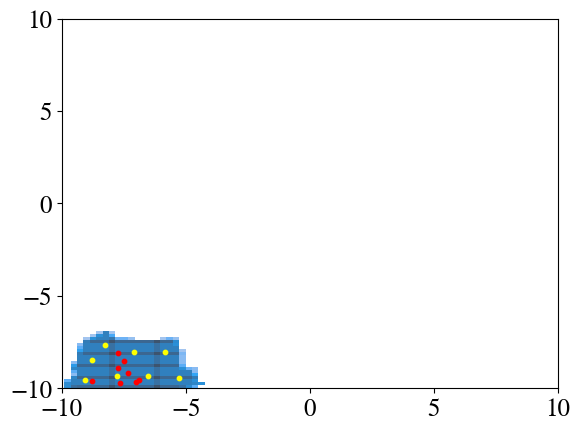

In [71]:
theta_region = thetas[region.flatten() == 1]
sns.histplot(x = theta_region[:,0], y = theta_region[:,1])

pred_rps = get_rps(trajectory[:5_000])
for n in range(N):
    plt.scatter(pred_rps[n,0], pred_rps[n,1], s=10, color="red")
    plt.scatter(true_rps[n,0], true_rps[n,1], s=10, color="yellow")

plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [67]:
import scipy.spatial
import itertools

def list_assoc(L1, L2, reverse=False):
    tree=scipy.spatial.KDTree(L2)
    assoc=[]
    for I1,point in enumerate(L1):
        _,I2 = tree.query(point,k=1)
        if reverse:
            assoc.append((I2,I1))
        else:
            assoc.append((I1,I2))
    return assoc

def get_opt_correspondence(true_rps, pred_rps):
    # some complication to ensure 1-1 correspondence
    true_to_pred_assoc_A = list_assoc(true_rps, pred_rps, reverse=False)
    true_to_pred_assoc_B = list_assoc(pred_rps, true_rps, reverse=True)
    true_to_pred_assoc   = list(set.intersection(set(true_to_pred_assoc_A), set(true_to_pred_assoc_B)))
    
    # exhaustively enumerate and match remainder: N here should be small, so N! should be manageable
    unmatched_true = list(range(N))
    unmatched_pred = list(range(N))
    [(unmatched_true.remove(assoc[0]), unmatched_pred.remove(assoc[1])) for assoc in true_to_pred_assoc]
    
    if len(unmatched_true) > 0:
        pred_permutations = list(itertools.permutations(unmatched_pred))
        dists = []
        for pred_permutation in pred_permutations:
            correspondence_dist = true_rps[unmatched_true] - pred_rps[pred_permutation,:]
            dists.append(np.sum(correspondence_dist ** 2))
        unmatched_opt = np.argmin(dists)

        true_to_pred_assoc += list(zip(unmatched_true, pred_permutations[unmatched_opt]))
    true_to_pred_assoc = np.array(sorted(true_to_pred_assoc)).astype(np.int32)
    return true_to_pred_assoc

def get_dist(true_rps, pred_rps):
    true_to_pred_assoc = get_opt_correspondence(true_rps, pred_rps)
    opt_correspondence_dist = true_rps[true_to_pred_assoc[:,0]] - pred_rps[true_to_pred_assoc[:,1]]
    return np.sum(opt_correspondence_dist ** 2)

In [68]:
ts = list(range(500, 5_001, 100))
dists = []
for t in ts:
    pred_rps = get_rps(trajectory[:t])
    pred_rps = np.vstack(pred_rps)
    dists.append(get_dist(true_rps, pred_rps))

<Axes: >

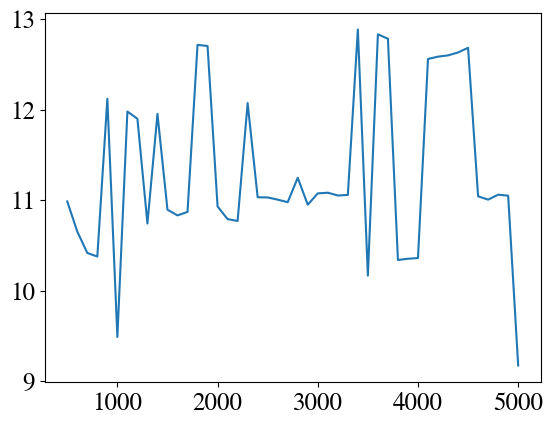

In [69]:
sns.lineplot(x=ts, y=dists)